In [1]:
!conda list

# packages in environment at C:\Users\d8\miniconda3\envs\boost:
#
# Name                    Version                   Build  Channel
anyio                     3.6.2              pyhd8ed1ab_0    conda-forge
argon2-cffi               21.3.0             pyhd8ed1ab_0    conda-forge
argon2-cffi-bindings      21.2.0           py38h294d835_2    conda-forge
asttokens                 2.2.1              pyhd8ed1ab_0    conda-forge
attrs                     22.2.0             pyh71513ae_0    conda-forge
babel                     2.11.0             pyhd8ed1ab_0    conda-forge
backcall                  0.2.0              pyh9f0ad1d_0    conda-forge
backports                 1.0                pyhd8ed1ab_3    conda-forge
backports.functools_lru_cache 1.6.4              pyhd8ed1ab_0    conda-forge
beautifulsoup4            4.11.1             pyha770c72_0    conda-forge
blas                      1.0                         mkl  
bleach                    5.0.1              pyhd8ed1ab_0    conda-forge


In [2]:
# remove preprocessed data
#unix
#!rm -rf data/processed
#windows
!rd /s /q "O:\Git\Provectus\2023\data-quality-abalone\data\processed"

In [3]:
from datetime import datetime

In [4]:
dt_start = datetime.utcnow()
print(dt_start)

2023-01-10 19:45:38.898844


In [5]:
import pandas as pd

In [6]:
import os
import sys
from pathlib import Path
from textwrap import dedent

In [7]:
STARS = 10 * '*'

In [8]:
## AS IT IS NOTEBOOK - we will show dataframes, not just print in logs

def show_full_dataframe(df: pd.DataFrame):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
        display(df)


def df_to_print(df: pd.DataFrame, name=None, nrows=3):
    print(f'{name}:')
    print(f'head({nrows}):')
    show_full_dataframe(df.head(nrows))
    print(f'tail({nrows}):')
    show_full_dataframe(df.tail(nrows))
    print(f'shape: {df.shape}')
    return ''

In [9]:
def _check_contents(path: Path, exts: list):
    """
    Check if folder contains files with extensions from exts list
    """
    exists_files = []
    for ext in exts:
        exists_files += list(path.rglob(f'*.{ext}'))

    if len(exists_files) > 0:
        pq_files_str = os.linesep + os.linesep.join(['\t' + str(f) for f in sorted(exists_files)]) + os.linesep
        raise ValueError(dedent(f"""
        Folder {path} already contains {exts} files:{pq_files_str}
        Saving in same folder can cause reading problems. Please, remove them or choose another folder.
        """))


def _log_size(name: str, df: pd.DataFrame):
    sz = sys.getsizeof(df) / 1024 ** 3
    print(f'size in GB: {sz}')
    print(df_to_print(df, name.upper()))


def parquet_save(output_folder_path: str, df: pd.DataFrame):
    output_folder_path = Path(output_folder_path)
    name = output_folder_path.name
    print(f'{STARS} SAVE TO PARQUET {name.upper()} {STARS}')
    _log_size(name, df)
    output_folder_path.mkdir(parents=True, exist_ok=True)
    _check_contents(output_folder_path, ['parquet'])
    save_path = output_folder_path / f'{name}.parquet'
    df.to_parquet(save_path)
    print(f'saved {name} to {save_path}')

In [10]:
def read_abalone(input_path: str, output_path: str):
    """
    Given is the attribute name, attribute type, the measurement unit and a
       brief description.  The number of rings is the value to predict: either
       as a continuous value or as a classification problem.

	Name		Data Type	Meas.	Description
	----		---------	-----	-----------
	Sex		nominal			M, F, and I (infant)
	Length		continuous	mm	Longest shell measurement
	Diameter	continuous	mm	perpendicular to length
	Height		continuous	mm	with meat in shell
	Whole weight	continuous	grams	whole abalone
	Shucked weight	continuous	grams	weight of meat
	Viscera weight	continuous	grams	gut weight (after bleeding)
	Shell weight	continuous	grams	after being dried
	Rings		integer			+1.5 gives the age in years

   Statistics for numeric domains:

		Length	Diam	Height	Whole	Shucked	Viscera	Shell	Rings
	Min	0.075	0.055	0.000	0.002	0.001	0.001	0.002	    1
	Max	0.815	0.650	1.130	2.826	1.488	0.760	1.005	   29
	Mean	0.524	0.408	0.140	0.829	0.359	0.181	0.239	9.934
	SD	0.120	0.099	0.042	0.490	0.222	0.110	0.139	3.224
	Correl	0.557	0.575	0.557	0.540	0.421	0.504	0.628	  1.0
    """
    col_names = [
        'Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 
        'Viscera weight', 'Shell weight', 'Rings'
    ]
    print(f'initial column names: {col_names}')
    col_names = ['_'.join(c.lower().split(' ')) for c in col_names]
    print(f'lowercase columns and replace space with underscore: {col_names}')
    dfs = []
    for p in Path(input_path).glob('*.csv'):
        print(f'reading: {str(p)}')
        dfs.append(pd.read_csv(
            p, sep=',', encoding='utf-8', names=col_names, 
            dtype = {
                'sex':               'str',
                'length':            'float',
                'diameter':          'float',
                'height':            'float',
                'whole_weight':      'float',
                'shucked_weight':    'float',
                'viscera_weight':    'float',
                'shell_weight':      'float',
                'rings':             'int'
            }
        ))

    parquet_save(output_path, pd.concat(dfs))

# I deliberately messed up one of the entries with an invalid value

In [11]:
# M,0.565,0.425,0.135,0.8115,0.341,0.1675,0.255,15
# whole_weight 0.8115 -> 100.0
# M,0.565,0.425,0.135,100.0,0.341,0.1675,0.255,15
# it has row index near to 90

In [12]:
SOURCE_DATA_PATH = Path('./data/source/')
PROCESSED_PATH = Path('./data/processed/')

In [13]:
abalone_path = PROCESSED_PATH / 'abalone'

In [14]:
read_abalone(SOURCE_DATA_PATH, abalone_path)

initial column names: ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']
lowercase columns and replace space with underscore: ['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight', 'rings']
reading: data\source\abalone.csv
********** SAVE TO PARQUET ABALONE **********
size in GB: 0.00045916996896266937
ABALONE:
head(3):


,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.15,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.07,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.21,9


tail(3):


,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.308,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.296,10
4176,M,0.710,0.555,0.195,1.9485,0.9455,0.3765,0.495,12


shape: (4177, 9)

saved abalone to data\processed\abalone\abalone.parquet


# make job step by step
## then we will combine them

In [15]:
abalone = pd.read_parquet(abalone_path)
abalone.dtypes

sex                object
length            float64
diameter          float64
height            float64
whole_weight      float64
shucked_weight    float64
viscera_weight    float64
shell_weight      float64
rings               int32
dtype: object

In [16]:
# just for example create boolean and int2str columns
abalone['diameter_bool'] = abalone['diameter'] > 0.5 
abalone['rings_str'] = abalone['rings'].astype(str)

In [17]:
import numpy as np

In [18]:
regression_cols = abalone.select_dtypes(include=np.number).columns
classification_cols = abalone.columns.difference(regression_cols)
print(f'classification_cols: {classification_cols}')
print(f'regression_cols: {regression_cols}')

print('if column wrongly marked as regression - cast it to string type before saving to parquet')

classification_cols: Index(['diameter_bool', 'rings_str', 'sex'], dtype='object')
regression_cols: Index(['length', 'diameter', 'height', 'whole_weight', 'shucked_weight',
       'viscera_weight', 'shell_weight', 'rings'],
      dtype='object')
if column wrongly marked as regression - cast it to string type before saving to parquet


In [19]:
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.model_selection import StratifiedKFold

In [20]:
from sklearn.preprocessing import LabelBinarizer
from scipy.special import xlogy

In [21]:
# copied and modified version of 
# https://github.com/scikit-learn/scikit-learn/blob/98cf537f5/sklearn/metrics/_classification.py#L2509
# which returns cross-entropy of each sample (without mean or sum)
def log_loss(y_true, y_pred, *, eps="auto", labels=None):
    eps = np.finfo(y_pred.dtype).eps if eps == "auto" else eps
    lb = LabelBinarizer()
    lb.fit(y_true)

    transformed_labels = lb.transform(y_true)

    if transformed_labels.shape[1] == 1:
        transformed_labels = np.append(
            1 - transformed_labels, transformed_labels, axis=1
        )

    # Clipping
    y_pred = np.clip(y_pred, eps, 1 - eps)

    # If y_pred is of single dimension, assume y_true to be binary
    # and then check.
    if y_pred.ndim == 1:
        y_pred = y_pred[:, np.newaxis]
    if y_pred.shape[1] == 1:
        y_pred = np.append(1 - y_pred, y_pred, axis=1)
        
    # Renormalize
    y_pred_sum = y_pred.sum(axis=1)
    y_pred = y_pred / y_pred_sum[:, np.newaxis]
    loss = -xlogy(transformed_labels, y_pred).sum(axis=1)
    return loss

In [22]:
k_folds = 5
reg_quantiles = 20

In [23]:
small_classes = {}
data_quality = {}
for c in abalone.columns:
    print(c)
    data_quality[c] = []
    # make a copy and ensure unique numeric index
    df = abalone.reset_index(drop=True)
    if c in regression_cols:
        # transform regression task to classification of quantile range
        df[c] = pd.qcut(df[c], reg_quantiles, duplicates='drop').astype(str)
        
    classes = df[c].value_counts().to_frame('counts')
    
    # rare labels (less than k_folds * 2 = 10 entries) automaticaly goes to outliers
    too_few_samples = classes[classes['counts'] < k_folds * 2]
    if too_few_samples.shape[0]:
        small_classes[c] = df.loc[df[c].isin(too_few_samples.index), c]
        df = df.drop(small_classes[c].index)
        classes = classes.drop(too_few_samples.index)
    
    if classes.shape[0] < 2: # constant value
        continue
    elif classes.shape[0] > 2: 
        multiclass = True
    else:
        multiclass = False
        
    loss = "MultiClass" if multiclass else "Logloss"
    params = {
        "verbose": False, 
        "od_wait": 5, # number of sequential iterations of not improved loss on validation set before training stops
        "use_best_model": True, 
        "auto_class_weights": 'Balanced',
        "loss_function": loss,
        "eval_metric": 'TotalF1:average=Weighted'
    }
    # print(params)
    
    # for simplicity encode class labels to integers
    classes['label'] = list(range(classes.shape[0]))
    print(classes)
    labels = df[[c]].copy()
    labels['int_label'] = labels[c].apply(lambda x: classes.loc[x, 'label'])
    inv_classes = classes.reset_index().set_index('label')
    
    skf = StratifiedKFold(n_splits=k_folds, random_state=0, shuffle=True)
    for i, (train_index, val_test_index) in enumerate(skf.split(np.zeros(df.shape[0]), labels[c])):
        train_dataset = Pool(
            data=df.drop(c, axis='columns').iloc[train_index],
            label=labels['int_label'].iloc[train_index],
            cat_features=classification_cols.drop(c, errors='ignore').to_list()
        )
        # make validation and test from val_test_index
        skf2 = StratifiedKFold(n_splits=2, random_state=0, shuffle=True)
        for val_index, test_index in skf2.split(np.zeros(val_test_index.shape[0]), labels[c].iloc[val_test_index]):
            val_dataset = Pool(
                data=df.drop(c, axis='columns').iloc[val_test_index[val_index]],
                label=labels['int_label'].iloc[val_test_index[val_index]],
                cat_features=classification_cols.drop(c, errors='ignore').to_list()
            )
            test_dataset = Pool(
                data=df.drop(c, axis='columns').iloc[val_test_index[test_index]],
                label=labels['int_label'].iloc[val_test_index[test_index]],
                cat_features=classification_cols.drop(c, errors='ignore').to_list()
            )
            clf = CatBoostClassifier(**params)
            clf.fit(train_dataset, eval_set=val_dataset)
            
            true_label = df[c].iloc[val_test_index[test_index]]
            pred_label = inv_classes.loc[np.array(clf.predict(test_dataset)).flatten(), 'index']
            cross_entropy = log_loss(
                labels['int_label'].iloc[val_test_index[test_index]], 
                clf.predict_proba(test_dataset)
            )
            preds = pd.DataFrame(
                index=df.index[val_test_index[test_index]],
                data=np.vstack((true_label, pred_label, cross_entropy)).T,
                columns=['true_label', 'pred_label', 'cross_entropy']
            )
            data_quality[c].append(preds)
    data_quality[c] = pd.concat(data_quality[c])


sex
   counts  label
M    1528      0
I    1342      1
F    1307      2
length
                counts  label
(0.625, 0.645]     269      0
(0.56, 0.575]      237      1
(0.525, 0.545]     232      2
(0.49, 0.51]       225      3
(0.585, 0.6]       224      4
(0.074, 0.295]     214      5
(0.295, 0.355]     214      6
(0.425, 0.45]      214      7
(0.39, 0.425]      213      8
(0.355, 0.39]      212      9
(0.545, 0.56]      210     10
(0.51, 0.525]      208     11
(0.69, 0.815]      207     12
(0.6, 0.615]       205     13
(0.47, 0.49]       202     14
(0.45, 0.47]       200     15
(0.615, 0.625]     181     16
(0.66, 0.69]       179     17
(0.645, 0.66]      175     18
(0.575, 0.585]     156     19
diameter
                counts  label
(0.435, 0.45]      284      0
(0.325, 0.35]      253      1
(0.395, 0.41]      245      2
(0.265, 0.3]       243      3
(0.48, 0.495]      232      4
(0.41, 0.425]      224      5
(0.054, 0.22]      219      6
(0.365, 0.38]      212      7
(0.522, 0.54

## anomaly detection

In [24]:
### combination of Robust and MinMax scalers
from scaling import scale_data

In [25]:
for c, cross_entropy in data_quality.items():
    scaled_loss, _, _ = scale_data(cross_entropy[['cross_entropy']])
    cross_entropy['scaled_loss'] = scaled_loss['cross_entropy']
    cross_entropy.columns = [f'{c}|{dq_c}' for dq_c in cross_entropy.columns]
data_quality_df = pd.concat(data_quality.values(), axis=1).sort_index()
data_quality_df

,sex|true_label,sex|pred_label,sex|cross_entropy,sex|scaled_loss,length|true_label,length|pred_label,length|cross_entropy,length|scaled_loss,diameter|true_label,diameter|pred_label,...,rings|cross_entropy,rings|scaled_loss,diameter_bool|true_label,diameter_bool|pred_label,diameter_bool|cross_entropy,diameter_bool|scaled_loss,rings_str|true_label,rings_str|pred_label,rings_str|cross_entropy,rings_str|scaled_loss
0,M,F,1.103805,0.202786,"(0.45, 0.47]","(0.45, 0.47]",1.478942,-0.12443,"(0.35, 0.365]","(0.35, 0.365]",...,0.756691,0.110051,0.0,0.0,0.547566,-0.001486,15,15,1.212018,-0.214044
1,M,I,1.402583,0.850565,"(0.295, 0.355]","(0.355, 0.39]",1.515301,-0.101923,"(0.22, 0.265]","(0.265, 0.3]",...,0.657382,-0.022643,0.0,0.0,0.568565,0.168818,7,7,1.558946,0.144356
2,F,I,1.257913,0.536908,"(0.525, 0.545]","(0.525, 0.545]",1.508623,-0.106057,"(0.41, 0.425]","(0.395, 0.41]",...,1.074609,0.534846,0.0,0.0,0.554074,0.051294,9,9,1.407349,-0.012254
3,M,F,1.136375,0.273401,"(0.425, 0.45]","(0.47, 0.49]",2.325816,0.39979,"(0.35, 0.365]","(0.325, 0.35]",...,0.520728,-0.205237,0.0,0.0,0.576678,0.234614,10,9,1.844681,0.43954
4,I,I,0.630047,-0.824366,"(0.295, 0.355]","(0.295, 0.355]",0.58877,-0.675451,"(0.22, 0.265]","(0.22, 0.265]",...,0.657382,-0.022643,0.0,0.0,0.449319,-0.798286,7,7,1.337493,-0.08442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4172,F,F,0.981478,-0.06243,"(0.56, 0.575]","(0.575, 0.585]",1.877444,0.122246,"(0.435, 0.45]","(0.435, 0.45]",...,0.57198,-0.136755,0.0,0.0,0.554074,0.051294,11,11,1.34548,-0.076169
4173,M,F,1.078709,0.148376,"(0.585, 0.6]","(0.56, 0.575]",2.358598,0.420083,"(0.435, 0.45]","(0.45, 0.46]",...,1.167819,0.659392,0.0,0.0,0.448749,-0.802910,10,10,1.891114,0.487509
4174,M,F,0.986824,-0.05084,"(0.585, 0.6]","(0.6, 0.615]",2.01651,0.208328,"(0.47, 0.48]","(0.47, 0.48]",...,0.417781,-0.342792,0.0,0.0,0.568311,0.166760,9,9,0.88049,-0.556536
4175,F,F,0.99061,-0.042632,"(0.615, 0.625]","(0.615, 0.625]",1.467439,-0.13155,"(0.48, 0.495]","(0.47, 0.48]",...,1.167819,0.659392,0.0,0.0,0.575456,0.224707,10,10,1.383233,-0.037167


In [26]:
scaled_loss = data_quality_df[[c for c in data_quality_df.columns if 'scaled_loss' in c]].copy()
scaled_loss

,sex|scaled_loss,length|scaled_loss,diameter|scaled_loss,height|scaled_loss,whole_weight|scaled_loss,shucked_weight|scaled_loss,viscera_weight|scaled_loss,shell_weight|scaled_loss,rings|scaled_loss,diameter_bool|scaled_loss,rings_str|scaled_loss
0,0.202786,-0.12443,0.093301,0.369391,-0.011733,0.032192,-0.223067,-0.129487,0.110051,-0.001486,-0.214044
1,0.850565,-0.101923,-0.438249,-0.385472,-0.523334,-0.432489,-0.446765,-0.343522,-0.022643,0.168818,0.144356
2,0.536908,-0.106057,0.087414,0.119374,-0.130275,0.148616,-0.006436,-0.121388,0.534846,0.051294,-0.012254
3,0.273401,0.39979,-0.013217,-0.136741,0.000731,-0.069484,-0.059676,0.102562,-0.205237,0.234614,0.43954
4,-0.824366,-0.675451,-0.633423,-0.781587,-0.692707,-0.286046,-0.672675,-0.800845,-0.022643,-0.798286,-0.08442
...,...,...,...,...,...,...,...,...,...,...,...
4172,-0.06243,0.122246,0.065192,0.167353,0.153084,0.05401,0.300593,0.057855,-0.136755,0.051294,-0.076169
4173,0.148376,0.420083,0.242443,0.346618,0.524701,0.052114,-0.030155,-0.05052,0.659392,-0.802910,0.487509
4174,-0.05084,0.208328,-0.055856,0.4926,0.485166,-0.000277,0.080168,0.186583,-0.342792,0.166760,-0.556536
4175,-0.042632,-0.13155,-0.107693,0.07241,-0.072094,-0.181376,0.188082,0.121878,0.659392,0.224707,-0.037167


In [27]:
row_scaled_loss, _, _ = scale_data(scaled_loss.mean(axis=1).to_frame('row_scaled_loss'))
scaled_loss['max_scaled_loss'] = scaled_loss.max(axis=1)
scaled_loss['row_scaled_loss'] = row_scaled_loss['row_scaled_loss']

In [28]:
import matplotlib.pyplot as plt

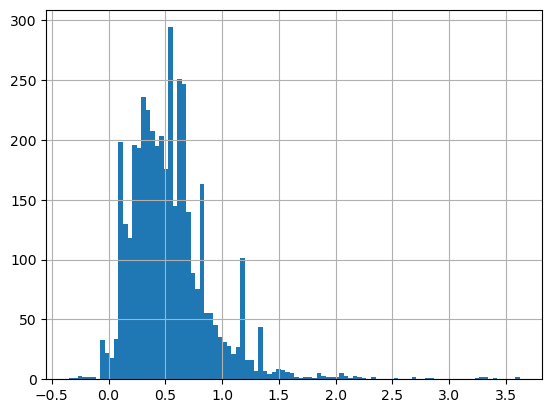

In [29]:
scaled_loss['max_scaled_loss'].hist(bins=100)
plt.show()

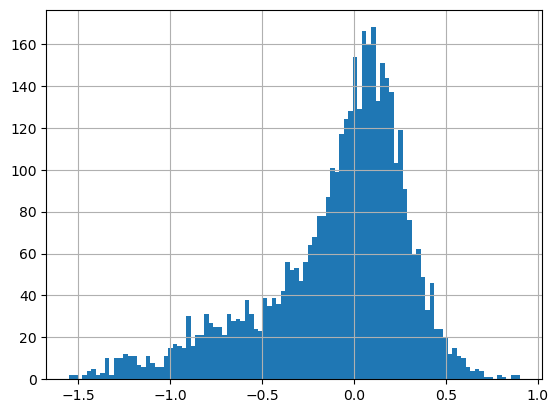

In [30]:
scaled_loss['row_scaled_loss'].hist(bins=100)
plt.show()

## as we can see - all "small" classes are NaN in scaled loss df

In [31]:
scaled_loss[scaled_loss.isna().any(axis=1)].sort_index()

,sex|scaled_loss,length|scaled_loss,diameter|scaled_loss,height|scaled_loss,whole_weight|scaled_loss,shucked_weight|scaled_loss,viscera_weight|scaled_loss,shell_weight|scaled_loss,rings|scaled_loss,diameter_bool|scaled_loss,rings_str|scaled_loss,max_scaled_loss,row_scaled_loss
232,-0.110892,0.57353,0.250503,-0.21436,-0.103633,0.448645,0.129532,-0.305282,-0.045742,-0.043229,NaN,0.573530,0.064873
236,-0.924559,-0.879789,-0.950404,-1.536964,-0.732705,-0.938509,-1.066441,-0.89667,2.084243,0.160202,NaN,2.084243,-0.983435
270,0.045395,0.369356,-0.222643,-0.433909,0.727279,0.751979,0.104028,-0.101759,-0.148967,-0.043229,NaN,0.751979,0.143314
275,0.109477,-0.016532,-0.329629,-0.558325,-0.251492,0.014341,-0.169026,-0.528497,0.542993,-0.055000,NaN,0.542993,-0.240002
294,-0.083361,0.219174,0.143851,0.154587,0.222089,0.233482,0.350756,0.299843,1.124,0.233636,NaN,1.124000,0.453172
313,-0.45712,0.140133,0.401838,-0.057805,0.471862,0.467677,0.039372,0.449141,0.061438,0.284625,NaN,0.471862,0.269505
314,0.158748,0.182513,-0.013649,0.068792,0.096294,0.634179,0.089258,0.68661,0.912121,0.224707,NaN,0.912121,0.476868
351,0.094397,0.170729,0.12613,0.335721,-0.046847,0.135701,0.413673,0.363751,0.061438,0.000000,NaN,0.413673,0.244979
433,0.191496,0.110831,0.187597,0.185441,0.086912,0.001349,0.141873,0.055913,0.542993,0.000000,NaN,0.542993,0.219814
480,-0.114261,-0.467843,-0.582645,-0.102221,-0.259493,0.176096,0.1377,-0.160955,1.124,-0.055000,NaN,1.124000,-0.083096


In [32]:
for c, data in small_classes.items():
    print(c)
    show_full_dataframe(data.sort_index())

rings_str


232     22
236      1
270     22
275     22
294     26
313     23
314     23
351     22
433     22
480     29
501     23
674     23
675     22
678     23
719      2
2108    27
2201    25
2209    27
2305    23
2334    23
2335    23
2436    23
3149    24
3280    24
Name: rings_str, dtype: object

### fill true_label with them

In [33]:
for c, data in small_classes.items():
    data_quality_df.loc[data.index, f'{c}|true_label'] = data

## now sort all data by anomaly score 
### which is number of NA and row score combination

In [34]:
anomaly_thresh = 1.5 # in std

In [35]:
scaled_loss['NA_count'] = scaled_loss.isna().sum(axis=1)
rare_class = scaled_loss['NA_count'] > 0
anomaly_value = scaled_loss['max_scaled_loss'] > anomaly_thresh
anomaly_combination = scaled_loss['row_scaled_loss'] > anomaly_thresh
scaled_loss['is_anomaly'] = rare_class | anomaly_value | anomaly_combination
# join with labels
labels = data_quality_df[[c for c in data_quality_df if any(s in c for s in ['true_label', 'pred_label'])]]
report = pd.concat([scaled_loss, labels], axis=1).reset_index().set_index(
    ['is_anomaly', 'NA_count', 'max_scaled_loss', 'row_scaled_loss', 'index']).sort_index(ascending=False)
report

sex|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                   
True       1         2.084243       -0.983435       236         -0.924559   
                     1.612730       -0.806010       719         -0.164718   
                     1.124000        0.503168       2201         0.045395   
                                     0.453172       294         -0.083361   
                                    -0.083096       480         -0.114261   
...                                                                   ...   
False      0        -0.232392       -1.398236       3902        -0.924559   
                    -0.235956       -1.012247       818         -0.947002   
                    -0.247167       -1.533253       1531        -1.387611   
                    -0.307804       -1.411552       1430        -0.608993   
                    -0.349141       -1.151198       2710        -0.418375   

                                                          length|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                      
True       1         2.084243       -0.983435       236            -0.879789   
                     1.612730       -0.806010       719            -0.890141   
                     1.124000        0.503168       2201            0.106513   
                                     0.453172       294             0.219174   
                                    -0.083096       480            -0.467843   
...                                                                      ...   
False      0        -0.232392       -1.398236       3902           -0.830769   
                    -0.235956       -1.012247       818             -0.79666   
                    -0.247167       -1.533253       1531           -0.916688   
                    -0.307804       -1.411552       1430           -0.900883   
                    -0.349141       -1.151198       2710           -0.882919   

                                                          diameter|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                        
True       1         2.084243       -0.983435       236              -0.950404   
                     1.612730       -0.806010       719              -0.944142   
                     1.124000        0.503168       2201              0.044493   
                                     0.453172       294               0.143851   
                                    -0.083096       480              -0.582645   
...                                                                        ...   
False      0        -0.232392       -1.398236       3902             -1.015751   
                    -0.235956       -1.012247       818              -0.509907   
                    -0.247167       -1.533253       1531             -0.962975   
                    -0.307804       -1.411552       1430             -0.962975   
                    -0.349141       -1.151198       2710             -0.729916   

                                                          height|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                      
True       1         2.084243       -0.983435       236            -1.536964   
                     1.612730       -0.806010       719            -1.403426   
                     1.124000        0.503168       2201            0.087419   
                                     0.453172       294             0.154587   
                                    -0.083096       480            -0.102221   
...                                                                      ...   
False      0        -0.232392       -1.398236       3902           -1.577931   
                    -0.235956       -1.012247       818            -0.489571   
                    -0.247167       -1.533253       1531           -1.690518   
                    -0.307804       -1.411552       1430           -

In [36]:
# take a look at all rows marked as anomaly
show_full_dataframe(report.loc[(True, slice(None), slice(None), slice(None), slice(None))])

sex|scaled_loss  \
NA_count max_scaled_loss row_scaled_loss index                   
1        2.084243        -0.983435       236         -0.924559   
         1.612730        -0.806010       719         -0.164718   
         1.124000         0.503168       2201         0.045395   
                          0.453172       294         -0.083361   
                         -0.083096       480         -0.114261   
         1.084344         0.784457       2209         0.099015   
         0.912121         0.476868       314          0.158748   
         0.893259         0.519028       678         -0.259115   
         0.776918         0.368723       675         -0.063757   
         0.773437         0.282918       501          0.045395   
         0.751979         0.143314       270          0.045395   
         0.696200         0.286832       2436        -0.035098   
         0.676248        -0.155446       3149        -0.114261   
                         -0.413933       2108        -0.282808   
         0.664035        -0.080269       3280        -0.078217   
         0.573530         0.064873       232         -0.110892   
         0.542993         0.219814       433          0.191496   
                         -0.240002       275          0.109477   
         0.508141         0.009815       674         -0.330089   
         0.471862         0.269505       313          -0.45712   
         0.413673         0.244979       351          0.094397   
         0.367018         0.269523       2335        -0.144986   
         0.282641         0.101560       2305         0.024387   
         0.061438        -0.853400       2334        -0.244939   
0        3.620900         0.662473       2397           3.6209   
         3.605877         0.644374       1385         3.605877   
         3.405470         0.615918       1958          3.40547   
         3.321757         0.681790       2123         3.321757   
                         -0.123750       136          3.321757   
         3.279076         0.868231       1699         3.279076   
         3.275440         0.901804       2962          3.27544   
         3.245714         0.050935       2117         3.245714   
         2.859272         0.062638       627          2.859272   
         2.811531         0.897666       2925         2.811531   
         2.671636         0.866469       3915         2.671636   
         2.670690         0.618248       90          -0.145559   
         2.519303         0.606914       3835         2.519303   
         2.344600         0.524354       944            2.3446   
         2.316438         0.582527       1324         2.316438   
         2.255641         0.086352       2134         2.255641   
         2.196988        -0.120256       653          2.196988   
                         -0.257145       643          2.196988   
         2.191290         0.202473       830           2.19129   
         2.184926         0.585660       2405         2.184926   
         2.156875        -0.195979       519          2.156875   
         2.143025        -0.010862       636          2.143025   
         2.103450         0.501436       576           2.10345   
         2.080915         0.690389       1685         2.080915   
         2.067801         0.245387       2239         2.067801   
                          0.149917       1267         2.067801   
         2.062681         0.376871       47           2.062681   
         2.059344         0.451261       1893         2.059344   
         2.041698        -0.114330       2490         2.041698   
         2.023796         0.167203       1570         2.023796   
         2.017476         0.000372       2097         2.017476   
         1.988149         0.469685       2394         1.988149   
         1.960678         0.011473       2641        -0.521223   
         1.927494         0.573132       3486          0.06523   
         1.918230         0.303456       4089         0.094028   
         1.895743    

In [37]:
# take a look at modified row
show_full_dataframe(report.loc[(slice(None), slice(None), slice(None), slice(None), list(range(90, 95)))])

sex|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                   
True       0        2.670690         0.618248       90          -0.145559   
False      0        0.294097         0.076009       91           0.136281   
                    0.721669         0.191404       92          -0.028998   
                    0.284625         0.085048       93           0.104597   
                    0.300824        -0.179645       94           0.028538   

                                                          length|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                      
True       0        2.670690         0.618248       90              0.479228   
False      0        0.294097         0.076009       91              0.082013   
                    0.721669         0.191404       92               0.10187   
                    0.284625         0.085048       93             -0.021426   
                    0.300824        -0.179645       94             -0.363688   

                                                          diameter|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                        
True       0        2.670690         0.618248       90                0.384377   
False      0        0.294097         0.076009       91                0.262048   
                    0.721669         0.191404       92                0.269539   
                    0.284625         0.085048       93               -0.254481   
                    0.300824        -0.179645       94               -0.211988   

                                                          height|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                      
True       0        2.670690         0.618248       90              0.679648   
False      0        0.294097         0.076009       91             -0.028149   
                    0.721669         0.191404       92             -0.064987   
                    0.284625         0.085048       93              0.149915   
                    0.300824        -0.179645       94             -0.340596   

                                                          whole_weight|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                            
True       0        2.670690         0.618248       90                     2.67069   
False      0        0.294097         0.076009       91                   -0.128331   
                    0.721669         0.191404       92                    0.004216   
                    0.284625         0.085048       93                    0.014163   
                    0.300824        -0.179645       94                   -0.311059   

                                                          shucked_weight|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                              
True       0        2.670690         0.618248       90                      0.712823   
False      0        0.294097         0.076009       91                     -0.020897   
                    0.721669         0.191404       92                      0.145469   
                    0.284625         0.085048       93                      0.058652   
                    0.300824        -0.179645       94                      0.300824   

                                                          viscera_weight|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                              
True       0        2.670690         0.618248       90                      0.689258   
False      0        0.294097         0.076009       91                      0.294097   
                    0.721669         0.191404       92                      0.006861   
                    0.284625         0.085048       93                      0.008612   
                    0.300824        -0.179645       94                   

# combine all together

In [38]:
def make_data_quality_report(
    input_path: str, output_path: str, ignore_columns: list = None,
    k_folds = 5, reg_quantiles = 20, anomaly_thresh=3.0,
):
    init_df = pd.read_parquet(input_path)
    if ignore_columns:
        init_df = init_df.drop(init_df, axis=1)
    regression_cols = init_df.select_dtypes(include=np.number).columns
    classification_cols = init_df.columns.difference(regression_cols)
    print(f'classification_cols: {classification_cols}')
    print(f'regression_cols: {regression_cols}')
    print('if column wrongly marked as regression - cast it to string type before saving to parquet')

    small_classes = {}
    data_quality = {}
    
    for c in init_df.columns:
        print(c)
        data_quality[c] = []
        # make a copy and ensure unique numeric index
        df = init_df.reset_index(drop=True)
        if c in regression_cols:
            # transform regression task to classification of quantile range
            df[c] = pd.qcut(df[c], reg_quantiles, duplicates='drop').astype(str)

        classes = df[c].value_counts().to_frame('counts')

        # rare labels (less than k_folds * 2 = 10 entries) automatically goes to outliers
        too_few_samples = classes[classes['counts'] < k_folds * 2]
        if too_few_samples.shape[0]:
            small_classes[c] = df.loc[df[c].isin(too_few_samples.index), c]
            df = df.drop(small_classes[c].index)
            classes = classes.drop(too_few_samples.index)

        if classes.shape[0] < 2: # constant value
            continue
        elif classes.shape[0] > 2: 
            multiclass = True
        else:
            multiclass = False

        loss = "MultiClass" if multiclass else "Logloss"
        params = {
            "verbose": False, 
            "od_wait": 5, 
            "use_best_model": True, 
            "auto_class_weights":'Balanced',
            "loss_function": loss,
            "eval_metric": 'TotalF1:average=Weighted'
        }
        # print(params)

        # for simplicity encode class labels to integers
        classes['label'] = list(range(classes.shape[0]))
        print(classes)
        labels = df[[c]].copy()
        labels['int_label'] = labels[c].apply(lambda x: classes.loc[x, 'label'])
        inv_classes = classes.reset_index().set_index('label')

        skf = StratifiedKFold(n_splits=k_folds, random_state=0, shuffle=True)
        for i, (train_index, val_test_index) in enumerate(skf.split(np.zeros(df.shape[0]), labels[c])):
            train_dataset = Pool(
                data=df.drop(c, axis='columns').iloc[train_index],
                label=labels['int_label'].iloc[train_index],
                cat_features=classification_cols.drop(c, errors='ignore').to_list()
            )
            # make validation and test from val_test_index
            skf2 = StratifiedKFold(n_splits=2, random_state=0, shuffle=True)
            test_val_splits_iterator = skf2.split(
                np.zeros(val_test_index.shape[0]), 
                labels[c].iloc[val_test_index]
            )
            for val_index, test_index in test_val_splits_iterator:
                val_dataset = Pool(
                    data=df.drop(c, axis='columns').iloc[val_test_index[val_index]],
                    label=labels['int_label'].iloc[val_test_index[val_index]],
                    cat_features=classification_cols.drop(c, errors='ignore').to_list()
                )
                test_dataset = Pool(
                    data=df.drop(c, axis='columns').iloc[val_test_index[test_index]],
                    label=labels['int_label'].iloc[val_test_index[test_index]],
                    cat_features=classification_cols.drop(c, errors='ignore').to_list()
                )
                clf = CatBoostClassifier(**params)
                clf.fit(train_dataset, eval_set=val_dataset)

                true_label = df[c].iloc[val_test_index[test_index]]
                pred_label = inv_classes.loc[np.array(clf.predict(test_dataset)).flatten(), 'index']
                cross_entropy = log_loss(
                    labels['int_label'].iloc[val_test_index[test_index]], 
                    clf.predict_proba(test_dataset)
                )
                preds = pd.DataFrame(
                    index=df.index[val_test_index[test_index]],
                    data=np.vstack((true_label, pred_label, cross_entropy)).T,
                    columns=['true_label', 'pred_label', 'cross_entropy']
                )
                data_quality[c].append(preds)
        data_quality[c] = pd.concat(data_quality[c])
    
    for c, cross_entropy in data_quality.items():
        scaled_loss, _, _ = scale_data(cross_entropy[['cross_entropy']])
        cross_entropy['scaled_loss'] = scaled_loss['cross_entropy']
        cross_entropy.columns = [f'{c}|{dq_c}' for dq_c in cross_entropy.columns]
    data_quality_df = pd.concat(data_quality.values(), axis=1).sort_index()
    
    scaled_loss = data_quality_df[[c for c in data_quality_df.columns if 'scaled_loss' in c]].copy()
    
    row_scaled_loss, _, _ = scale_data(scaled_loss.mean(axis=1).to_frame('row_scaled_loss'))
    scaled_loss['max_scaled_loss'] = scaled_loss.max(axis=1)
    scaled_loss['row_scaled_loss'] = row_scaled_loss['row_scaled_loss']
    
    for c, true_data in small_classes.items():
        data_quality_df.loc[true_data.index, f'{c}|true_label'] = true_data
    
    scaled_loss['NA_count'] = scaled_loss.isna().sum(axis=1)
    rare_class = scaled_loss['NA_count'] > 0
    anomaly_value = scaled_loss['max_scaled_loss'] > anomaly_thresh
    anomaly_combination = scaled_loss['row_scaled_loss'] > anomaly_thresh
    scaled_loss['is_anomaly'] = rare_class | anomaly_value | anomaly_combination
    # join with labels
    labels = data_quality_df[[c for c in data_quality_df if any(s in c for s in ['true_label', 'pred_label'])]]
    report = pd.concat([scaled_loss, labels], axis=1).reset_index().set_index(
        ['is_anomaly', 'NA_count', 'max_scaled_loss', 'row_scaled_loss', 'index']).sort_index(ascending=False)
    
    parquet_save(output_path, report)

In [39]:
report_path = PROCESSED_PATH / 'data_quality_report'

In [40]:
make_data_quality_report(abalone_path, report_path)

classification_cols: Index(['sex'], dtype='object')
regression_cols: Index(['length', 'diameter', 'height', 'whole_weight', 'shucked_weight',
       'viscera_weight', 'shell_weight', 'rings'],
      dtype='object')
if column wrongly marked as regression - cast it to string type before saving to parquet
sex
   counts  label
M    1528      0
I    1342      1
F    1307      2
length
                counts  label
(0.625, 0.645]     269      0
(0.56, 0.575]      237      1
(0.525, 0.545]     232      2
(0.49, 0.51]       225      3
(0.585, 0.6]       224      4
(0.074, 0.295]     214      5
(0.295, 0.355]     214      6
(0.425, 0.45]      214      7
(0.39, 0.425]      213      8
(0.355, 0.39]      212      9
(0.545, 0.56]      210     10
(0.51, 0.525]      208     11
(0.69, 0.815]      207     12
(0.6, 0.615]       205     13
(0.47, 0.49]       202     14
(0.45, 0.47]       200     15
(0.615, 0.625]     181     16
(0.66, 0.69]       179     17
(0.645, 0.66]      175     18
(0.575, 0.585]   

sex|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                   
False      0        2.355898        0.666478        90          -0.013097   
                    2.330345        0.361759        1039        -0.291411   
                    2.292395        0.359990        2962         2.292395   

                                                          length|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                      
False      0        2.355898        0.666478        90              0.135941   
                    2.330345        0.361759        1039            0.428172   
                    2.292395        0.359990        2962             0.27106   

                                                          diameter|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                        
False      0        2.355898        0.666478        90                0.601608   
                    2.330345        0.361759        1039              0.399302   
                    2.292395        0.359990        2962              0.032731   

                                                          height|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                      
False      0        2.355898        0.666478        90              0.276541   
                    2.330345        0.361759        1039           -0.123074   
                    2.292395        0.359990        2962            0.058991   

                                                          whole_weight|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                            
False      0        2.355898        0.666478        90                    2.355898   
                    2.330345        0.361759        1039                  0.045232   
                    2.292395        0.359990        2962                  0.081169   

                                                          shucked_weight|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                              
False      0        2.355898        0.666478        90                      0.812333   
                    2.330345        0.361759        1039                   -0.231618   
                    2.292395        0.359990        2962                   -0.002903   

                                                          viscera_weight|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                              
False      0        2.355898        0.666478        90                      0.700204   
                    2.330345        0.361759        1039                      0.1019   
                    2.292395        0.359990        2962                    0.075983   

                                                          shell_weight|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                            
False      0        2.355898        0.666478        90                    0.294615   
                    2.330345        0.361759        1039                   0.14237   
                    2.292395        0.359990        2962                 -0.144926   

                                                          rings|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                     
False      0        2.355898        0.666478        90            -0.285386   
                    2.330345        0.361759        1039           2.330345   
                    2.292395        0.359990        2962           0.124657   

                                                          sex|true_label  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                  
False      0        2.355898        0.666478        90                 M   
                    2.330345        0.361759        1039               F   
               

tail(3):


sex|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                   
False      0        -0.916922       -1.468501       3377        -0.941904   
                    -0.917636       -1.493224       2172         -0.91773   
                    -0.934403       -1.437817       2457        -0.941904   

                                                          length|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                      
False      0        -0.916922       -1.468501       3377            -0.94105   
                    -0.917636       -1.493224       2172            -0.94105   
                    -0.934403       -1.437817       2457           -1.052705   

                                                          diameter|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                        
False      0        -0.916922       -1.468501       3377             -0.983315   
                    -0.917636       -1.493224       2172             -0.980055   
                    -0.934403       -1.437817       2457             -1.005451   

                                                          height|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                      
False      0        -0.916922       -1.468501       3377           -1.430837   
                    -0.917636       -1.493224       2172           -1.502944   
                    -0.934403       -1.437817       2457           -1.033966   

                                                          whole_weight|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                            
False      0        -0.916922       -1.468501       3377                 -0.916922   
                    -0.917636       -1.493224       2172                 -0.952342   
                    -0.934403       -1.437817       2457                 -0.934403   

                                                          shucked_weight|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                              
False      0        -0.916922       -1.468501       3377                   -1.011451   
                    -0.917636       -1.493224       2172                   -0.917636   
                    -0.934403       -1.437817       2457                   -0.969498   

                                                          viscera_weight|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                              
False      0        -0.916922       -1.468501       3377                   -1.131703   
                    -0.917636       -1.493224       2172                   -1.163992   
                    -0.934403       -1.437817       2457                   -0.963761   

                                                          shell_weight|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                            
False      0        -0.916922       -1.468501       3377                 -1.045129   
                    -0.917636       -1.493224       2172                 -0.980832   
                    -0.934403       -1.437817       2457                 -1.085778   

                                                          rings|scaled_loss  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                     
False      0        -0.916922       -1.468501       3377          -1.274361   
                    -0.917636       -1.493224       2172          -1.488644   
                    -0.934403       -1.437817       2457          -1.480014   

                                                          sex|true_label  \
is_anomaly NA_count max_scaled_loss row_scaled_loss index                  
False      0        -0.916922       -1.468501       3377               I   
                    -0.917636       -1.493224       2172               I   
               

shape: (4177, 27)

saved data_quality_report to data\processed\data_quality_report\data_quality_report.parquet


In [41]:
# as we can see, changing this value does not have a dramatic effect on the gradient boosting model,
# however, the changed row is in the top 1 on the anomaly scale
# and it will be revealed when using a more rigid threshold value , for example 2.0

In [42]:
dt_end = datetime.utcnow()
print(dt_end)
print(f'total execution time: {dt_end - dt_start}')

2023-01-10 19:51:20.153787
total execution time: 0:05:41.254943


In [43]:
pd.read_parquet(report_path).to_excel('report.xlsx')